In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom

In [ ]:
!pip install pynrrd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import time
import os
import sys
import pydicom
import nrrd
import scipy.ndimage
import scipy.misc
import pickle
import random
import skimage

from IPython.display import display, clear_output, HTML, Image
import matplotlib.animation as animation

from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter


train_path_pickle = '/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/pickles/train.pkl'
val_path_pickle = '/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/pickles/valid.pkl'
test_path_pickle = '/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/pickles/test.pkl'

save_model_dir = '/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/saved_models'
save_model_logs = '/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/saved_logs'

%matplotlib inline

# **Data Reading and visualization**

In [ ]:
def return_dcm(file_path, check_term = 'Prostate'): #/images
    # Read all DCM (slices) files within a directory and order the files based on filename
    out_dcm = {}
    for dirName, subdirList, fileList in os.walk(file_path):
        c_dcm = []
        cur_name = ""
        dir_split = dirName.split("/")
        for f_chk in dir_split:
            if check_term in f_chk:
                cur_name = f_chk
        for filename in fileList:
            if ".dcm" in filename.lower():
                name = int((os.path.splitext(filename)[0]).split('-')[-1])
                c_dcm.append((os.path.join(dirName,filename), name))
        if len(c_dcm) > 0:
            c_dcm = sorted(c_dcm, key = lambda t: t[1]) # Sort into correct order
            out_dcm[cur_name] = [c[0] for c in c_dcm]   # Store in dictionary
    return out_dcm

def return_nrrd(file_path):
    # Read all NRRD (annotation) files within a directory
    out_nrrd = {}
    for dirName, subdirList, fileList in os.walk(file_path):
        for filename in fileList:
            print(filename)
            if ".nrrd" in filename.lower():
                name = filename.split('_')[0]
                name = name.split('.')[0] # Get annotation name and store in dictionary
                out_nrrd[name] = os.path.join(dirName,filename)
    return out_nrrd

def get_dataset(data_dir, anns_dir):
    # Match DCM volumes with corresponding annotation files
    data_out = []
    shapes = {}
    d_dcm = return_dcm(data_dir)
    d_nrrd = return_nrrd(anns_dir)
    for i in d_nrrd:
        seg, opts = nrrd.read(d_nrrd[i])
        voxels = np.zeros(np.shape(seg))
        for j in range(len(d_dcm[i])):
            dicom_ref = pydicom.read_file(d_dcm[i][j])
            found = False
            chk_val = dicom_ref[("0020", "0013")].value
            # Make sure you get the right slice! This is a bizarre specification thing related to DCM dataset
            # Note, if you just use the default filename ordering you get mismatched slices!
            if int(chk_val.__str__()) - 1 < np.shape(voxels)[-1]:
                voxels[:, :, int(chk_val.__str__()) - 1] = dicom_ref.pixel_array
            else:
                print('Index: ',str(int(chk_val.__str__()) - 1), ' too large for ', i, ' skipping!')
        # Rotate and flip annotations to match volumes
        seg = scipy.ndimage.rotate(seg, 90, reshape = False)
        for i in range(np.shape(seg)[2]):
            cur_img = np.squeeze(seg[:, :, i])
            seg[:, :, i] = np.flipud(cur_img)
        # Store volume shapes (for debug)
        if voxels.shape in shapes:
            shapes[voxels.shape] += 1
        else:
            shapes[voxels.shape] = 1
        # Saves data
        data_out.append((voxels, seg))
    return data_out

def plot_slice(slice_in, is_anns = False, num_anns = 4):
    # Plot a slice of data - can either be raw image data or corresponding annotation
    slice_in = np.squeeze(slice_in)
    plt.figure()
    plt.set_cmap(plt.bone())
    if is_anns:
        plt.pcolormesh(slice_in, vmin = 0, vmax = num_anns - 1)
    else:
        plt.pcolormesh(slice_in)
    plt.show()


In [ ]:
# .dcm data files
data_train_dir = '/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/train/images'
data_leader_dir = '/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/leaderboard/images'
data_test_dir = '/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/test/images'

# .nrrd annotation files
anns_train_dir = '/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/train/masks'
anns_leader_dir = '/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/leaderboard/masks'
anns_test_dir = '/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/test/masks'

train = get_dataset(data_train_dir, anns_train_dir)
valid = get_dataset(data_leader_dir, anns_leader_dir)
test = get_dataset(data_test_dir, anns_test_dir)

if not os.path.exists('/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/pickles'):
    os.makedirs('/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/pickles')
pickle.dump(file = open('/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/pickles/train.pkl', 'wb'), obj = train)
pickle.dump(file = open('/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/pickles/valid.pkl', 'wb'), obj = valid)
pickle.dump(file = open('/content/drive/MyDrive/Data Science Padova/Semester 3/Vision and Cognitive Systems/Project/dataset/pickles/test.pkl', 'wb'), obj = test)

print("\nTraining scans:", len(train), "\t\t Scan slices:", np.sum([x.shape[2] for x,_ in train]),
      "\nValidation scans:", len(valid), "\t\t Scan slices:", np.sum([x.shape[2] for x,_ in valid]),
      "\nTesting scans: ", len(test), "\t\t Scan slices:", np.sum([x.shape[2] for x,_ in test]))
print("Sample 3D scans' shapes:", train[1][0].shape, valid[1][0].shape, test[1][0].shape)

ProstateDx-01-0014.nrrd
ProstateDx-01-0001.nrrd
ProstateDx-01-0013.nrrd
ProstateDx-01-0021.nrrd
ProstateDx-01-0023.nrrd
ProstateDx-01-0019.nrrd
ProstateDx-01-0076.nrrd
ProstateDx-01-0075.nrrd
ProstateDx-01-0073.nrrd
ProstateDx-01-0071.nrrd
ProstateDx-01-0074.nrrd
ProstateDx-01-0063.nrrd
ProstateDx-01-0060.nrrd
ProstateDx-01-0059.nrrd
ProstateDx-01-0082.nrrd
ProstateDx-01-0058.nrrd
ProstateDx-01-0055.nrrd
ProstateDx-01-0052.nrrd
ProstateDx-01-0056.nrrd
ProstateDx-01-0054.nrrd
ProstateDx-01-0044.nrrd
ProstateDx-01-0042.nrrd
ProstateDx-01-0038.nrrd
ProstateDx-01-0043.nrrd
ProstateDx-01-0080.nrrd
ProstateDx-01-0035.nrrd
ProstateDx-01-0028.nrrd
ProstateDx-01-0011.nrrd
ProstateDx-01-0005.nrrd
Prostate3T-01-0012.nrrd
Prostate3T-01-0019.nrrd
Prostate3T-01-0001.nrrd
Prostate3T-01-0002.nrrd
Prostate3T-01-0013.nrrd
Prostate3T-01-0003.nrrd
Prostate3T-01-0004.nrrd
Prostate3T-01-0005.nrrd
Prostate3T-01-0006.nrrd
Prostate3T-01-0007.nrrd
Prostate3T-01-0009.nrrd
Prostate3T-01-0010.nrrd
Prostate3T-01-00

<ipython-input-24-ef1cfa57a9a2>:52: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  seg = scipy.ndimage.interpolation.rotate(seg, 90, reshape = False)


Prostate3T-02-0005_truth.nrrd
ProstateDx-02-0001_truth.nrrd
ProstateDx-02-0003_truth.nrrd
Prostate3T-02-0001_truth.nrrd
ProstateDx-02-0002_truth.nrrd
ProstateDx-02-0004_truth.nrrd
Prostate3T-02-0004_truth.nrrd
Prostate3T-02-0002_truth.nrrd
ProstateDx-02-0005_truth.nrrd
Prostate3T-02-0003_truth.nrrd
masks.npy
Prostate3T-03-0003_truth.nrrd
Prostate3T-03-0001_truth.nrrd
Prostate3T-03-0005_truth.nrrd
ProstateDx-03-0005_truth.nrrd
Prostate3T-03-0002_truth.nrrd
ProstateDx-03-0001_truth.nrrd
ProstateDx-03-0002_truth.nrrd
Prostate3T-03-0004_truth.nrrd
ProstateDx-03-0003_truth.nrrd
ProstateDx-03-0004_truth.nrrd
masks.npy

Training scans: 60 		 Scan slices: 1544 
Validation scans: 10 		 Scan slices: 261 
Testing scans:  10 		 Scan slices: 271
Sample 3D scans' shapes: (400, 400, 32) (400, 400, 32) (400, 400, 34)


In [ ]:
def multi_slice_viewer(images, masks=None, num_classes=2, interval=200, no_axis=False, save_path=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    ims = []

    if masks is not None:
        assert len(images) == len(masks), "Number of images and masks should be the same."

    for i in range(images.shape[-1]):
        ax1 = axs[0]
        im1 = ax1.imshow(images[:, :, i], cmap='bone')
        ax1.set_title('Image')

        if masks is not None:
            ax2 = axs[1]
            im2 = ax2.imshow(masks[:, :, i], cmap='viridis', alpha=0.5, vmin=0, vmax=num_classes)
            ax2.set_title('Mask')

            if no_axis:
                ax2.set_axis_off()

            ims.append([im1, im2])
        else:
            ims.append([im1])

        if no_axis:
            ax1.set_axis_off()

    ani = animation.ArtistAnimation(fig, ims, interval=interval, blit=True)

    # Save animation as GIF
    if not save_path:
      ani.save('animation.gif', writer='imagemagick', fps=int(1000/interval))
    else:
      ani.save(save_path, writer='imagemagick', fps=int(1000/interval))

    # Display the animation
    HTML(ani.to_jshtml())

In [ ]:
img_id = 12
multi_slice_viewer(train[img_id][0], train[img_id][1])

<IPython.core.display.Javascript object>

In [ ]:
display(Image(filename='/content/animation.gif'))

# **Augmentation**

In [ ]:
def rotate(voxels, lbls, theta = None):
    # Rotate volume by a minor angle (+/- 10 degrees: determined by investigation of dataset variability)
    if theta is None:
        theta = random.randint(-10, 10)
    vox_new = scipy.ndimage.rotate(voxels, theta, reshape = False)
    lbl_new = scipy.ndimage.rotate(lbls, theta, reshape = False)
    return vox_new, lbl_new


def scale_and_crop(voxels, lbls):
    # Scale the volume by a minor size and crop around centre (can also modify for random crop)
    o_s = voxels.shape
    r_s = [0]*len(o_s)
    scale_factor = random.uniform(1, 1.2)
    vox_zoom = scipy.ndimage.zoom(voxels, scale_factor, order=1)
    lbl_zoom = scipy.ndimage.zoom(lbls, scale_factor, order=0)
    new_shape = vox_zoom.shape
    # Start with offset
    for i in range(len(o_s)):
        if new_shape[i] == 1:
            r_s[i] = 0
            continue
        r_c = int(((new_shape[i] - o_s[i]) - 1)/2)
        r_s[i] = r_c
    r_e = [r_s[i] + o_s[i] for i in list(range(len(o_s)))]
    vox_zoom = vox_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1], r_s[2]:r_e[2]]
    lbl_zoom = lbl_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1], r_s[2]:r_e[2]]
    return vox_zoom, lbl_zoom


def grayscale_variation(voxels, lbls):
    # Introduce a random global increment in gray-level value of volume.
    im_min = np.min(voxels)
    im_max = np.max(voxels)
    mean = np.random.normal(0, 0.1)
    smp = np.random.normal(mean, 0.01, size = np.shape(voxels))
    voxels = voxels + im_max*smp
    voxels[voxels <= im_min] = im_min # Clamp to min value
    voxels[voxels > im_max] = im_max  # Clamp to max value
    return voxels, lbls


def elastic_deformation(voxels, lbls, alpha=None, sigma=None, mode="constant", cval=0, is_random=False):
    # Apply elastic deformation/distortion to the wolume
    # Adapted from: https://tensorlayer.readthedocs.io/en/stable/_modules/tensorlayer/prepro.html#elastic_transform
    if alpha == None:
        alpha=voxels.shape[1]*3.
    if sigma == None:
        sigma=voxels.shape[1]*0.07
    if is_random is False:
        random_state = np.random.RandomState(None)
    else:
        random_state = np.random.RandomState(int(time.time()))

    if len(voxels.shape) == 3:
        voxels = np.reshape(voxels, (voxels.shape[0], voxels.shape[1], voxels.shape[2], 1) )
        lbls = np.reshape(lbls, (lbls.shape[0], lbls.shape[1], lbls.shape[2], 1) )

    shape = (voxels.shape[0], voxels.shape[1])
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode=mode, cval=cval) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode=mode, cval=cval) * alpha
    x_, y_ = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x_ + dx, (-1, 1)), np.reshape(y_ + dy, (-1, 1))

    new_voxels = np.zeros(voxels.shape)
    new_lbls = np.zeros(lbls.shape)
    for i in range(voxels.shape[2]): # apply the same distortion to each slice within the volume
        new_voxels[:,:,i,0] = map_coordinates(voxels[:,:,i,0], indices, order=1).reshape(shape)
        new_lbls[:,:,i,0] = map_coordinates(lbls[:,:,i,0], indices, order=1).reshape(shape)

    return new_voxels, new_lbls


def get_random_perturbation(voxels, lbls):
    # Generate a random perturbation of the input feature + label
    new_voxels, new_lbls = voxels, lbls
    p=0.6
    if random.random() < p:
        new_voxels, new_lbls = rotate(new_voxels, new_lbls)
    if random.random() < p:
        new_voxels, new_lbls = scale_and_crop(new_voxels, new_lbls)
    if random.random() < p:
        new_voxels, new_lbls = grayscale_variation(new_voxels, new_lbls)
    if random.random() < p:
        new_voxels, new_lbls = elastic_deformation(new_voxels, new_lbls)
    return new_voxels, new_lbls


def plot_augmentation(img_org, ann_org, img_aug, ann_aug, title_aug='Augmented', axis_off=True):
    if len(ann_org) == 0:
        n = 1  # Annotations are not plotted
    else:
        n = 2  # Annotations are plotted

    plt.close()  # Close previous figure
    plt.figure(figsize=(5, 5))

    plt.subplot(n, 2, 1)
    if axis_off:
        plt.axis('off')
    plt.title("Original scan")
    plt.imshow(img_org, cmap=plt.cm.gray)

    plt.subplot(n, 2, 2)
    if axis_off:
        plt.axis('off')
    plt.title(title_aug)
    plt.imshow(img_aug, cmap=plt.cm.gray)

    if n > 1:
        plt.subplot(n, 2, 3)
        if axis_off:
            plt.axis('off')
        plt.title("Original annotation")
        plt.imshow(ann_org, cmap=plt.cm.gray)

        plt.subplot(n, 2, 4)
        if axis_off:
            plt.axis('off')
        plt.title(title_aug)
        plt.imshow(ann_aug, cmap=plt.cm.gray)
        #display(Image(filename='/content/animation.gif'))
    plt.tight_layout()
    plt.show()


In [ ]:
# Load the dataset if first execution
train = pickle.load(file = open(train_path_pickle, 'rb'))
val = pickle.load(file = open(val_path_pickle, 'rb'))
test = pickle.load(file = open(test_path_pickle, 'rb'))

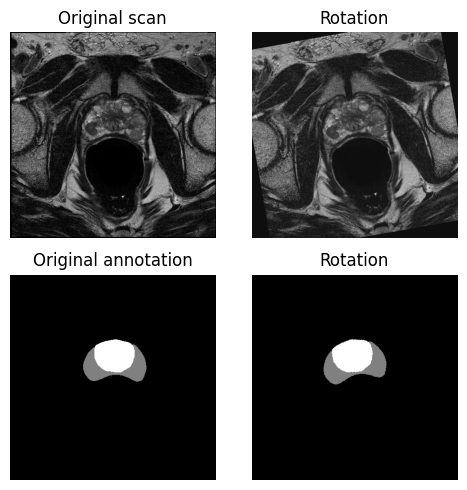

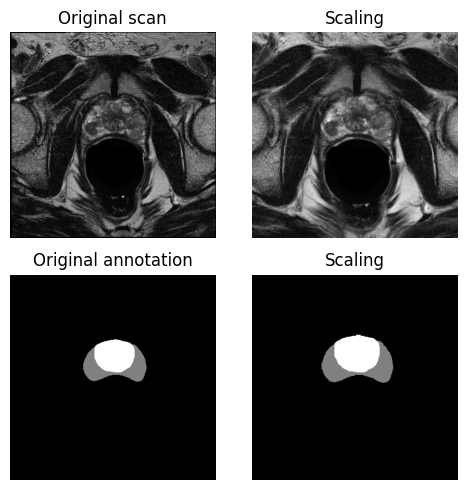

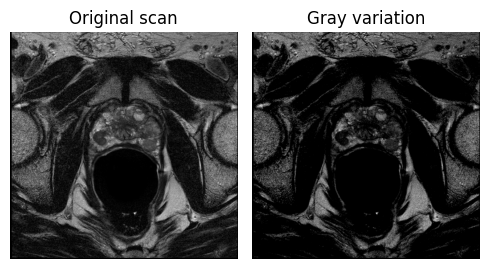

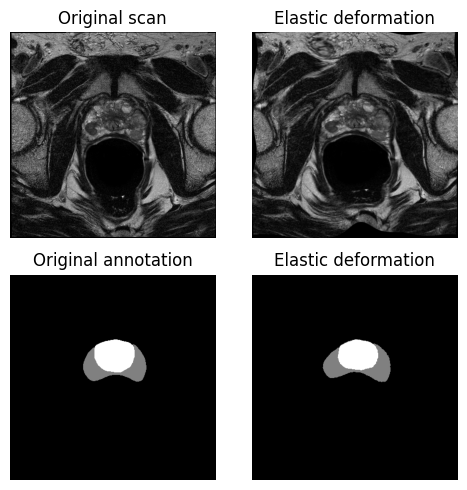

In [ ]:
img_id = 7
slice_id = 12

imgs_org = train[img_id][0]
anns_org = train[img_id][1]

img_org = train[img_id][0][:,:,slice_id]
ann_org = train[img_id][1][:,:,slice_id]

# Rotation
imgs_aug, anns_aug = rotate(imgs_org, anns_org, theta=10)
plot_augmentation(img_org, ann_org, imgs_aug[:,:,slice_id], anns_aug[:,:,slice_id], title_aug='Rotation')

# Scaling
imgs_aug, anns_aug = scale_and_crop(imgs_org, anns_org)
plot_augmentation(img_org, ann_org, imgs_aug[:,:,slice_id], anns_aug[:,:,slice_id], title_aug='Scaling')

# Gray value variation
imgs_aug, anns_aug = grayscale_variation(imgs_org, anns_org)
plot_augmentation(img_org, [], imgs_aug[:,:,slice_id], [], title_aug='Gray variation')

# Elastic deformation (smooth dense deformation field)
imgs_aug, anns_aug = elastic_deformation(imgs_org, anns_org)
plot_augmentation(img_org, ann_org, imgs_aug[:,:,slice_id,0], anns_aug[:,:,slice_id,0], title_aug='Elastic deformation')

# **Evaluations**

In [ ]:
INPUT_SIZE = 120 # Input feature width/height
OUTPUT_SIZE = 120 # Output feature width/height (as defined by model)
INPUT_DEPTH = 12 # Input depth
OFF_IMAGE_FILL = 0 # What to fill an image with if padding is required to make Tensor
OFF_LABEL_FILL = 0 # What to fill a label with if padding is required to make Tensor
OUTPUT_CLASSES = 3 # Number of output classes in dataset: the fourth class can be used for unlabelled datapoints (not needed for this dataset)

# Get 'natural' OUTPUT_DEPTH according to scipy method
io_zoom = OUTPUT_SIZE/INPUT_SIZE
zero_chk = np.zeros((INPUT_SIZE, INPUT_SIZE, INPUT_DEPTH))
OUTPUT_DEPTH = np.shape(scipy.ndimage.zoom(zero_chk, io_zoom, order = 1))[-1]
# Alternatively, this can be forced to match expected tensorflow output (note, extra padding is applied if depth mismatch)
OUTPUT_DEPTH = 12


def get_scaled_input(data, min_i = INPUT_SIZE, min_o = OUTPUT_SIZE, depth = INPUT_DEPTH,
                    depth_out = OUTPUT_DEPTH, image_fill = OFF_IMAGE_FILL,
                    label_fill = OFF_LABEL_FILL, n_classes = OUTPUT_CLASSES, norm_max = 500):

    # Takes raw data (x, y) and scales to match desired input and output sizes to feed into Tensorflow
    # Pads and normalises input and also moves axes around to orientation expected by tensorflow

    input_scale_factor = min_i/data[0].shape[0]
    output_scale_factor = min_o/data[0].shape[0]

    vox_zoom = None
    lbl_zoom = None

    if not input_scale_factor == 1:
        vox_zoom = scipy.ndimage.zoom(data[0], input_scale_factor, order = 1)
        # Order 1 is bilinear - fast and good enough
    else:
        vox_zoom = data[0]

    if not output_scale_factor == 1:
        lbl_zoom = scipy.ndimage.zoom(data[1], output_scale_factor, order = 0)
        # Order 0 is nearest neighbours: VERY IMPORTANT as it ensures labels are scaled properly (and stay discrete)
    else:
        lbl_zoom = data[1]

    lbl_pad = label_fill*np.ones((min_o, min_o, depth_out - lbl_zoom.shape[-1]))
    lbl_zoom = np.concatenate((lbl_zoom, lbl_pad), 2)
    lbl_zoom = lbl_zoom[np.newaxis, :, :, :]

    vox_pad = image_fill*np.ones((min_i, min_i, depth - vox_zoom.shape[-1]))
    vox_zoom = np.concatenate((vox_zoom, vox_pad), 2)

    max_val = np.max(vox_zoom)
    if not np.max(vox_zoom) == 0:
        vox_zoom = vox_zoom * norm_max/np.max(vox_zoom)

    vox_zoom = vox_zoom[np.newaxis, :, :, :]
    vox_zoom = np.swapaxes(vox_zoom, 0, -1)
    lbl_zoom = np.swapaxes(lbl_zoom, 0, -1)
    # Swap axes

    return vox_zoom, lbl_zoom

def upscale_segmentation(lbl, shape_desired):
    # Returns scaled up label for a given input label and desired shape. Required for Mean IOU calculation

    scale_factor = shape_desired[0]/lbl.shape[0]
    lbl_upscale = scipy.ndimage.zoom(lbl, scale_factor, order = 0)
    # Order 0 EVEN more important here
    lbl_upscale = lbl_upscale[:, :, :shape_desired[-1]]
    if lbl_upscale.shape[-1] < shape_desired[-1]:
        pad_zero = OFF_LABEL_FILL*np.zeros((shape_desired[0], shape_desired[1], shape_desired[2] - lbl_upscale.shape[-1]))
        lbl_upscale = np.concatenate((lbl_upscale, pad_zero), axis = -1)
    return lbl_upscale

def swap_axes(pred):
    # Swap those axes
    pred = np.swapaxes(pred, -1, 0)
    pred = np.squeeze(pred)
    return pred


def get_label_accuracy(pred, lbl_original):
    # Get pixel-wise labelling accuracy (DEMO metric)

    # Swap axes back
    pred = swap_axes(pred)
    pred_upscale = upscale_segmentation(pred, np.shape(lbl_original))
    return 100*np.sum(np.equal(pred_upscale, lbl_original))/np.prod(lbl_original.shape)


def get_mean_iou(pred, lbl_original, num_classes = OUTPUT_CLASSES, ret_full = False, reswap = False):
    # Get mean IOU between input predictions and target labels. Note, method implicitly resizes as needed
    # Ret_full - returns the full iou across all classes
    # Reswap - if lbl_original is in tensorflow format, swap it back into the format expected by plotting tools (+ format of raw data)

    # Swap axes back
    pred = swap_axes(pred)
    if reswap:
        lbl_original = swap_axes(lbl_original)
    pred_upscale = upscale_segmentation(pred, np.shape(lbl_original))
    iou = [1]*num_classes
    for i in range(num_classes):
        test_shape = np.zeros(np.shape(lbl_original))
        test_shape[pred_upscale == i] = 1
        test_shape[lbl_original == i] = 1
        full_sum = int(np.sum(test_shape))
        test_shape = -1*np.ones(np.shape(lbl_original))
        test_shape[lbl_original == i] = pred_upscale[lbl_original == i]
        t_p = int(np.sum(test_shape == i))
        if not full_sum == 0:
            iou[i] = t_p/full_sum
    if ret_full:
        return iou
    else:
        return np.mean(iou)

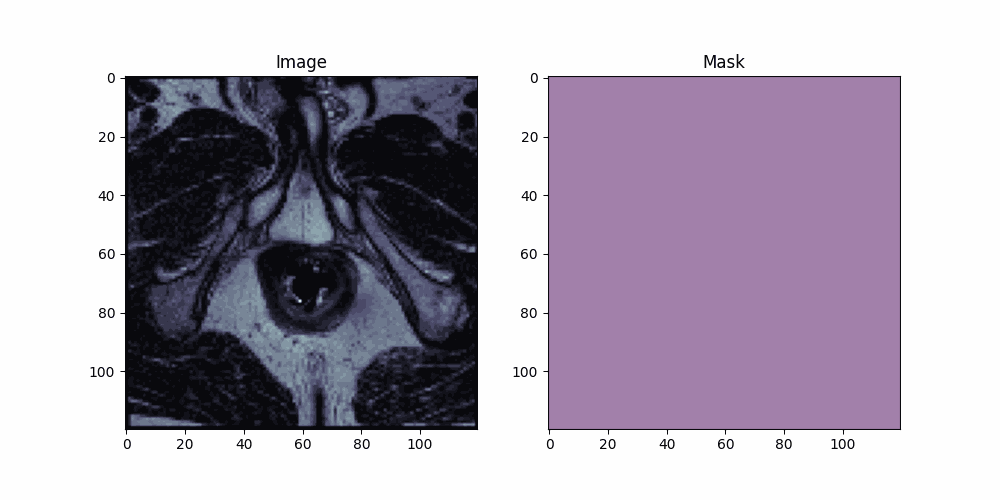

Mean IOU with itself
[1.0, 1.0, 1.0]
Mean IOU with original labels
[0.9940452158541022, 0.6379698596916681, 0.7964209597311025]


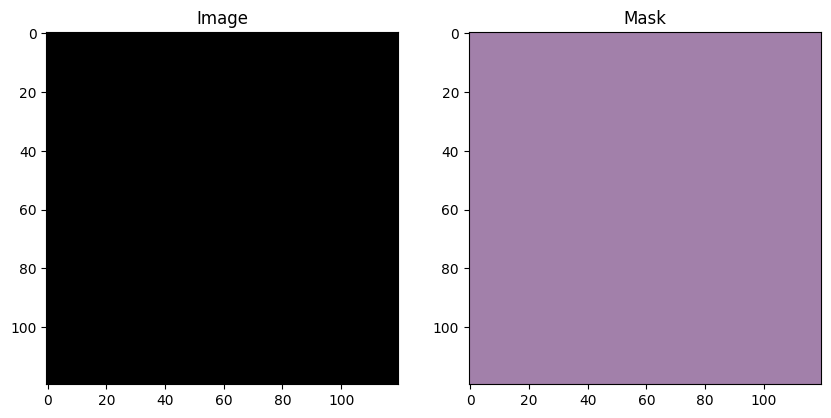

In [ ]:
dataset = train
save_animation = 'upscaled.gif'
x, y = get_scaled_input(dataset[img_id]) # Shows that this works - can check x,y shapes if needed
x_swap = swap_axes(x)
y_upscale = upscale_segmentation(swap_axes(y), np.shape(swap_axes(x)))
multi_slice_viewer(x_swap, y_upscale, save_path=save_animation)  # View scaled images and labels together
display(Image(filename=f'/content/{save_animation}'))

# Compute mean iou with itself & upsampled data
x, y = get_scaled_input(dataset[img_id])
print('Mean IOU with itself')
print(get_mean_iou(y, y, ret_full = True, reswap = True))
print('Mean IOU with original labels')
print(get_mean_iou(y, dataset[img_id][1], ret_full = True, reswap = False))